# Proyecto 2: Optimización de carga de datos


Se pide que :

- Compara Pandas vs. PyTorch DataLoader para cargar nlp_prueba_cc0c2_large.csv (10,000 oraciones). 
- Mide tiempo y RAM (con psutil) para lectura completa vs. batching (batch_size=32). 
- Usa collate_fn para padding simple. 
- Fija semillas.

In [2]:
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import psutil
import time

import random

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [4]:
import os, sys, time, math, re

def set_seeds(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    g = torch.Generator()
    g.manual_seed(seed)
    return g
  
SEED = 42
GENERATOR = set_seeds(SEED)

print({
    "python": sys.version,
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "torch": torch.__version__,
    "psutil": psutil.__version__,
})

{'python': '3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]', 'pandas': '2.2.2', 'numpy': '1.26.4', 'torch': '2.3.1+cpu', 'psutil': '5.9.8'}


In [14]:
# Primero debemos de leer el dataset csv

CSV_PATH = "data/nlp_prueba_cc0c2_large.csv"
COL_DATA = "Texto"
LABEL_COL = "Categoría"
BATCH_SIZE = 32

LABEL2ID = {"Negativo": 0, "Neutral": 1, "Positivo": 2}
ID2LABEL = {v:k for k,v in LABEL2ID.items()}

PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"

# Tokenizer simple 
tokenizer_regex = re.compile(
    r"[A-Za-zÁÉÍÓÚÜÑáéíóúüñ]+(?:[-'][A-Za-zÁÉÍÓÚÜÑáéíóúüñ]+)*|\d+(?:[.,]\d+)?"
)

def simple_tokenize(text: str):
    return tokenizer_regex.findall(str(text))

def build_vocab_from_texts(texts, min_freq: int = 1):
    from collections import Counter
    cnt = Counter()
    for t in texts:
        cnt.update(simple_tokenize(t))
    # Orden por frecuencia desc y luego alfabético
    vocab_list = [PAD_TOKEN, UNK_TOKEN] + [tok for tok, f in sorted(cnt.items(), key=lambda x: (-x[1], x[0])) if f >= min_freq]
    stoi = {tok: i for i, tok in enumerate(vocab_list)}
    itos = {i: tok for tok, i in stoi.items()}
    return stoi, itos

def numericalize(tokens, stoi):
    unk_id = stoi.get(UNK_TOKEN, 1)
    return [stoi.get(tok, unk_id) for tok in tokens]

In [18]:
df = pd.read_csv(CSV_PATH)

assert {COL_DATA, LABEL_COL}.issubset(df.columns), f"El CSV debe tener columnas: {TEXT_COL}, {LABEL_COL}"

texts = df[COL_DATA].astype(str).tolist()
labels = df[LABEL_COL].map(LABEL2ID).astype(int).tolist()

stoi, itos = build_vocab_from_texts(texts, min_freq=1)
PAD_ID = stoi[PAD_TOKEN]
UNK_ID = stoi[UNK_TOKEN]

vocab_size = len(stoi)
num_classes = len(LABEL2ID)
print(f"Vocab size: {vocab_size}, clases: {num_classes}, muestras: {len(texts)}")

Vocab size: 73, clases: 3, muestras: 10005


In [13]:
# Dataset Pytorch
class CustomDataset(Dataset):
    def __init__(self, texts, labels, stoi):
        self.texts = texts
        self.labels = labels
        self.stoi = stoi
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        toks = simple_tokenize(self.texts[idx])
        ids = numericalize(toks, self.stoi)
        # Tensors
        x = torch.tensor(ids, dtype=torch.long)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

def collate_pad(batch):
    # batch: list of (tensor_ids, label)
    xs, ys = zip(*batch)
    lengths = torch.tensor([len(x) for x in xs], dtype=torch.long)
    padded = pad_sequence(xs, batch_first=True, padding_value=PAD_ID)
    ys = torch.stack(ys)
    return padded, lengths, ys

In [19]:
dataset_pytorch = CustomDataset(texts,labels,stoi)

loader = DataLoader(
    dataset_pytorch,
    batch_size=BATCH_SIZE,
    shuffle=True,                 # shuffling estable con GENERATOR
    generator=GENERATOR,
    collate_fn=collate_pad,
    num_workers=0,                # puedes probar >0 si el entorno lo permite
    pin_memory=False
)

# Para comparar también sin shuffle
loader_noshuffle = DataLoader(
    dataset_pytorch,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_pad,
    num_workers=0,
    pin_memory=False
)

len_batches = math.ceil(len(dataset_pytorch) / BATCH_SIZE)
print(f"Batches esperados: {len_batches}")


Batches esperados: 313


In [24]:
proc = psutil.Process(os.getpid())

def rss_mb():
    return proc.memory_info().rss / (1024 ** 2)

class Stopwatch:
    def __enter__(self):
        self.t0 = time.perf_counter()
        return self
    def __exit__(self, exc_type, exc, tb):
        self.elapsed = time.perf_counter() - self.t0

def run_and_measure_pandas_full(df, batch_size=32):
    peak_mb = rss_mb()
    t0 = time.perf_counter()
    # Preprocesamiento completo en memoria
    all_ids = [torch.tensor(numericalize(simple_tokenize(t), stoi), dtype=torch.long) for t in df[COL_DATA].astype(str)]
    all_lbl = torch.tensor(df[LABEL_COL].map(LABEL2ID).astype(int).tolist())
    peak_mb = max(peak_mb, rss_mb())
    # Simular epoch iterando en batches
    n = len(all_ids)
    for i in range(0, n, batch_size):
        xs = all_ids[i:i+batch_size]
        ys = all_lbl[i:i+batch_size]
        _ = pad_sequence(xs, batch_first=True, padding_value=PAD_ID)  # padding simple
        # Simular cómputo ligero
        _ = ys.sum().item()
        peak_mb = max(peak_mb, rss_mb())
    elapsed = time.perf_counter() - t0
    return {"time_s": elapsed, "peak_ram_mb": peak_mb}

def run_and_measure_pandas_streaming(csv_path, chunksize=32):
    peak_mb = rss_mb()
    t0 = time.perf_counter()
    # Leer por chunks (streaming)
    for chunk in pd.read_csv(csv_path, chunksize=chunksize):
        texts_c = chunk[COL_DATA].astype(str).tolist()
        labels_c = chunk[LABEL_COL].map(LABEL2ID).astype(int).tolist()
        xs = [torch.tensor(numericalize(simple_tokenize(t), stoi), dtype=torch.long) for t in texts_c]
        ys = torch.tensor(labels_c)
        _ = pad_sequence(xs, batch_first=True, padding_value=PAD_ID)
        _ = ys.sum().item()
        peak_mb = max(peak_mb, rss_mb())
    elapsed = time.perf_counter() - t0
    return {"time_s": elapsed, "peak_ram_mb": peak_mb}

def run_and_measure_torch_dataloader(dl):
    peak_mb = rss_mb()
    t0 = time.perf_counter()
    for xb, lengths, yb in dl:
        # Simular cómputo ligero
        _ = (xb.sum() + yb.sum() + lengths.sum()).item()
        peak_mb = max(peak_mb, rss_mb())
    elapsed = time.perf_counter() - t0
    return {"time_s": elapsed, "peak_ram_mb": peak_mb}

In [26]:
results = {}

print(">> Pandas (lectura completa en memoria) ...")
results["pandas_full"] = run_and_measure_pandas_full(df, batch_size=BATCH_SIZE)
print(results["pandas_full"])

print("\n>> Pandas (streaming por chunksize) ...")
results["pandas_stream"] = run_and_measure_pandas_streaming(CSV_PATH, chunksize=BATCH_SIZE)
print(results["pandas_stream"])

print("\n>> PyTorch DataLoader (shuffle=True) ...")
results["dataloader_shuffle"] = run_and_measure_torch_dataloader(loader)
print(results["dataloader_shuffle"])

print("\n>> PyTorch DataLoader (shuffle=False) ...")
results["dataloader_noshuffle"] = run_and_measure_torch_dataloader(loader_noshuffle)
print(results["dataloader_noshuffle"])

# Resumen en DataFrame
res_df = pd.DataFrame(results).T
res_df["time_per_1k_samples_s"] = res_df["time_s"] * (1000.0 / len(dataset_pytorch))
res_df = res_df[["time_s", "time_per_1k_samples_s", "peak_ram_mb"]]
res_df

>> Pandas (lectura completa en memoria) ...
{'time_s': 0.17494710002210923, 'peak_ram_mb': 255.30078125}

>> Pandas (streaming por chunksize) ...
{'time_s': 0.9574515999993309, 'peak_ram_mb': 255.37109375}

>> PyTorch DataLoader (shuffle=True) ...
{'time_s': 0.2484444000001531, 'peak_ram_mb': 255.36328125}

>> PyTorch DataLoader (shuffle=False) ...
{'time_s': 0.2413620000006631, 'peak_ram_mb': 255.3671875}


,time_s,time_per_1k_samples_s,peak_ram_mb
pandas_full,0.174947,0.017486,255.300781
pandas_stream,0.957452,0.095697,255.371094
dataloader_shuffle,0.248444,0.024832,255.363281
dataloader_noshuffle,0.241362,0.024124,255.367188


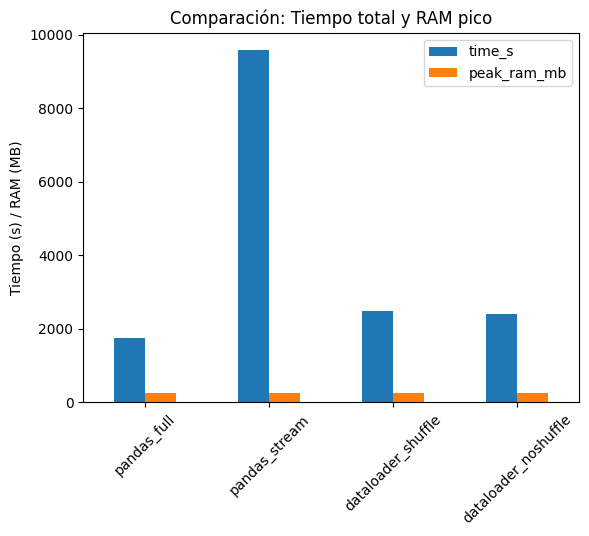

In [35]:
import matplotlib.pyplot as plt

ax = res_df[["time_s", "peak_ram_mb"]].plot(kind="bar", rot=45, title="Comparación: Tiempo total y RAM pico")
ax.set_ylabel("Tiempo (s) / RAM (MB)")
plt.show()